# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, CatBoostRegressor

from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from time import time

In [2]:
RANDOM_STATE = 12345

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('/datasets/autos.csv')

In [5]:
display(data.head(3))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [6]:
display(data.tail(3))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [7]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [8]:
display(data.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Удалим не нужное

In [9]:
data = data.drop(["DateCrawled", "DateCreated", "NumberOfPictures", "PostalCode", "LastSeen"], axis = 1)

In [10]:
print("Кол-во дупликатов:",data.duplicated().sum())

Кол-во дупликатов: 27543


Удалим дупликаты:

In [11]:
data = data.drop_duplicates().reset_index(drop = True)
print("Кол-во дупликатов:",data.duplicated().sum())

Кол-во дупликатов: 0


In [12]:
print("Кол-во пропусков:")
display(data.isna().sum())

Кол-во пропусков:


Price                    0
VehicleType          35249
RegistrationYear         0
Gearbox              17578
Power                    0
Model                18532
Kilometer                0
RegistrationMonth        0
FuelType             31122
Brand                    0
Repaired             66427
dtype: int64

В данных присутствует приличное количество пропусков. Но к ним стоит вернуться после окончания анализа данных так как часть пропусков сможет быть закрыта при решении других проблем.

**Price**

In [13]:
display(data["Price"].describe())

count    326826.000000
mean       4403.747330
std        4518.209808
min           0.000000
25%        1000.000000
50%        2700.000000
75%        6350.000000
max       20000.000000
Name: Price, dtype: float64

<AxesSubplot:>

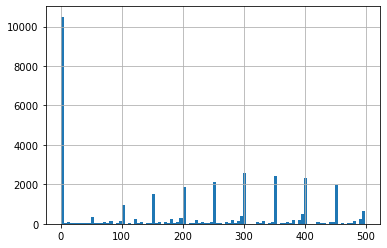

In [14]:
data[data['Price']<500]['Price'].hist(bins = 100)

По графику видно, что присутствует большое количество объявлений с ценной в 0, данные объявления нужно удалить так как они не являются настоящими и плохо повлияют на наше обучение.

In [15]:
data = data[data["Price"]>10]

**Power**

In [16]:
display(data["Power"].describe())

count    316203.000000
mean        111.107567
std         194.023605
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

<AxesSubplot:>

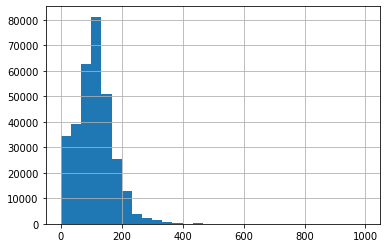

In [17]:
data[data['Power']<1000]['Power'].hist(bins = 30)

По графику можно увидеть выбросы со значением "Power" более 500. Следственно, их стоит удалить: 

In [18]:
data = data[data["Power"]<500]

**Registration year**

In [19]:
display(data["RegistrationYear"].describe())

count    315756.000000
mean       2004.075587
std          79.394444
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

При анализе данных "Registration year" можно увидеть большое количество не настоящих годов. Удалим:

In [20]:
data = data[(data["RegistrationYear"]>1950) & (data["RegistrationYear"]<2022)]

Вернемся к пропускам: 

In [21]:
print("Кол-во пропусков:")
display(data.isna().sum())

Кол-во пропусков:


Price                    0
VehicleType          31496
RegistrationYear         0
Gearbox              15141
Power                    0
Model                16382
Kilometer                0
RegistrationMonth        0
FuelType             27657
Brand                    0
Repaired             60978
dtype: int64

Стало лучше, за счет удаления строк, но проблема все равно присутствует. Так как пропуски не в самых важных данных, то заменим их на "unknown"

In [22]:
for col in ["VehicleType", "Repaired", "FuelType", "Gearbox", "Model"]:
    data[col] = data[col].fillna('unknown')

**Вывод:**

- Данные и типы данных соответсвуют описанию;
- Дубликаты устранены;
- Пропуски устранены.

## Подготовка выборок

Подготовим данные под обучение моделей: 

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315515 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              315515 non-null  int64 
 1   VehicleType        315515 non-null  object
 2   RegistrationYear   315515 non-null  int64 
 3   Gearbox            315515 non-null  object
 4   Power              315515 non-null  int64 
 5   Model              315515 non-null  object
 6   Kilometer          315515 non-null  int64 
 7   RegistrationMonth  315515 non-null  int64 
 8   FuelType           315515 non-null  object
 9   Brand              315515 non-null  object
 10  Repaired           315515 non-null  object
dtypes: int64(5), object(6)
memory usage: 28.9+ MB


Данные "VehicleType","Gearbox","FuelType","Brand" и "Repaired" приобразуем методом OHE:

In [24]:
data = pd.get_dummies(data, columns= ["VehicleType","Gearbox","FuelType","Brand","Repaired"], drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315515 entries, 0 to 326825
Data columns (total 64 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Price                    315515 non-null  int64 
 1   RegistrationYear         315515 non-null  int64 
 2   Power                    315515 non-null  int64 
 3   Model                    315515 non-null  object
 4   Kilometer                315515 non-null  int64 
 5   RegistrationMonth        315515 non-null  int64 
 6   VehicleType_convertible  315515 non-null  uint8 
 7   VehicleType_coupe        315515 non-null  uint8 
 8   VehicleType_other        315515 non-null  uint8 
 9   VehicleType_sedan        315515 non-null  uint8 
 10  VehicleType_small        315515 non-null  uint8 
 11  VehicleType_suv          315515 non-null  uint8 
 12  VehicleType_unknown      315515 non-null  uint8 
 13  VehicleType_wagon        315515 non-null  uint8 
 14  Gearbox_manual      

Так как в столбце "Model" много разных значений, то преобразуем его методом ordinal:

In [25]:
encoder = OrdinalEncoder()
encoder.fit(data[["Model"]])
data["Model"] = encoder.transform(data[["Model"]])

Разделим данные на признаки и на целевой признак: 

In [26]:
target = data["Price"]
features = data.drop("Price", axis = 1)

Разделим данные на три выборки: тренировочная, валидационная и тестовая в соотношении 8:1:1

In [27]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=RANDOM_STATE)

In [28]:
print("Размер features_valid:",features_valid.shape)
print("Размер features_test:",features_test.shape)
print("Размер features_train:",features_train.shape)
print("Размер target_valid:",target_valid.shape)
print("Размер target_test:",target_test.shape)
print("Размер target_train:",target_train.shape)

Размер features_valid: (31551, 63)
Размер features_test: (31552, 63)
Размер features_train: (252412, 63)
Размер target_valid: (31551,)
Размер target_test: (31552,)
Размер target_train: (252412,)


**Вывод:**

- Данные готовы для тренировки моделей и их проверки. 

## Обучение моделей

Воспользуемся несколькими моделями машинного обучения:
- LinearRegression;
- RandomForest;
- DecisionTree;
- LightGBM;
- CatBoost.

Для проверки верности предсказание воспользуемся метрикой RMSE:

In [29]:
def rmse(predict,true):
    square_distance = (np.array(predict) - np.array(true)) ** 2
    mean_square_distance = square_distance.mean()
    return np.sqrt(mean_square_distance)

In [30]:
def score_print(predicted,true):
    print("RMSE:",round(rmse(predicted,true),2))
    return round(rmse(predicted,true),2)

In [31]:
models_result = pd.DataFrame(columns = ["RMSE","TrainTime","PredictionTime","1st Importance","2nd Importance","3rd Importance"],
                             index = ["LinearRegression_auto",
                                      "RandomForestRegressor_friedman_mse","RandomForestRegressor_poisson",
                                      "DecisionTreeRegressor_friedman_mse","DecisionTreeRegressor_poisson",
                                      "LGBMRegressor_gbdt","LGBMRegressor_dart",
                                      "CatBoostRegressor_SymmetricTree","CatBoostRegressor_Depthwise",
                                      "CatBoostRegressor_Lossguide","DummyRegressor"])

### sklearn

#### Linear Regression

**LinearRegression_auto**

In [32]:
%%time
start_time = time()

model = LinearRegression()
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_valid)
prediction_time = time()

models_result["RMSE"]["LinearRegression_auto"] = score_print(predicted,target_valid)
models_result["TrainTime"]["LinearRegression_auto"] = round(train_time - start_time,2)
models_result["PredictionTime"]["LinearRegression_auto"] = round(prediction_time - train_time,2)

RMSE: 2857.57
CPU times: user 2.54 s, sys: 966 ms, total: 3.5 s
Wall time: 3.47 s


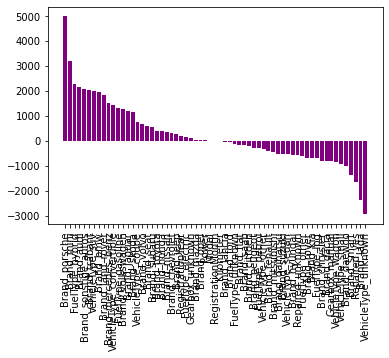

In [33]:
df = pd.DataFrame(data={"Features": features.columns,"Importance": model.coef_}).sort_values(by="Importance",ascending=False)
plt.bar(x=df["Features"],height=df["Importance"],color="purple")
plt.xticks(rotation="vertical")
plt.show()

models_result["1st Importance"]["LinearRegression_auto"] = df["Features"][0]
models_result["2nd Importance"]["LinearRegression_auto"] = df["Features"][1]
models_result["3rd Importance"]["LinearRegression_auto"] = df["Features"][2]

#### Random Forest

**RandomForestRegressor_friedman_mse**

In [34]:
%%time
start_time = time()

model = RandomForestRegressor(criterion="friedman_mse",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_valid)
prediction_time = time()

models_result["RMSE"]["RandomForestRegressor_friedman_mse"] = score_print(predicted,target_valid)
models_result["TrainTime"]["RandomForestRegressor_friedman_mse"] = round(train_time - start_time,2)
models_result["PredictionTime"]["RandomForestRegressor_friedman_mse"] = round(prediction_time - train_time,2)

RMSE: 1712.1
CPU times: user 3min 26s, sys: 2 s, total: 3min 28s
Wall time: 3min 28s


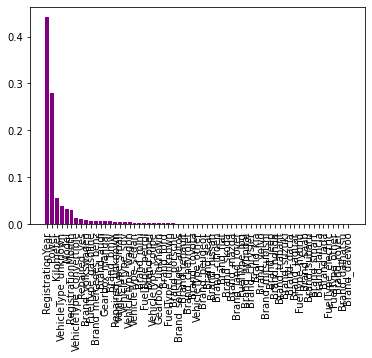

In [35]:
df = pd.DataFrame(data={"Features": features.columns,"Importance": model.feature_importances_}).sort_values(by="Importance",ascending=False)
plt.bar(x=df["Features"],height=df["Importance"],color="purple")
plt.xticks(rotation="vertical")
plt.show()

models_result["1st Importance"]["RandomForestRegressor_friedman_mse"] = df["Features"][0]
models_result["2nd Importance"]["RandomForestRegressor_friedman_mse"] = df["Features"][1]
models_result["3rd Importance"]["RandomForestRegressor_friedman_mse"] = df["Features"][2]

**RandomForestRegressor_poisson**

In [36]:
%%time
start_time = time()

model = RandomForestRegressor(criterion="poisson",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_valid)
prediction_time = time()

models_result["RMSE"]["RandomForestRegressor_poisson"] = score_print(predicted,target_valid)
models_result["TrainTime"]["RandomForestRegressor_poisson"] = round(train_time - start_time,2)
models_result["PredictionTime"]["RandomForestRegressor_poisson"] = round(prediction_time - train_time,2)

RMSE: 1974.31
CPU times: user 9min 59s, sys: 3.67 s, total: 10min 3s
Wall time: 10min 3s


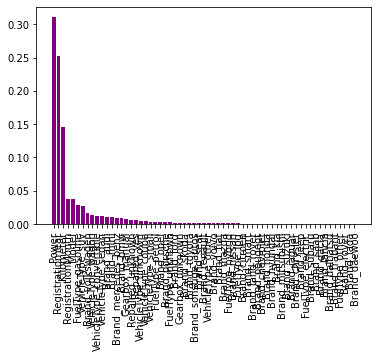

In [37]:
df = pd.DataFrame(data={"Features": features.columns,"Importance": model.feature_importances_}).sort_values(by="Importance",ascending=False)
plt.bar(x=df["Features"],height=df["Importance"],color="purple")
plt.xticks(rotation="vertical")
plt.show()

models_result["1st Importance"]["RandomForestRegressor_poisson"] = df["Features"][0]
models_result["2nd Importance"]["RandomForestRegressor_poisson"] = df["Features"][1]
models_result["3rd Importance"]["RandomForestRegressor_poisson"] = df["Features"][2]

#### Decision Tree

**DecisionTreeRegressor_friedman_mse**

In [38]:
%%time
start_time = time()

model = DecisionTreeRegressor(criterion="friedman_mse",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_valid)
prediction_time = time()

models_result["RMSE"]["DecisionTreeRegressor_friedman_mse"] = score_print(predicted,target_valid)
models_result["TrainTime"]["DecisionTreeRegressor_friedman_mse"] = round(train_time - start_time,2)
models_result["PredictionTime"]["DecisionTreeRegressor_friedman_mse"] = round(prediction_time - train_time,2)

RMSE: 2219.73
CPU times: user 3.14 s, sys: 160 ms, total: 3.3 s
Wall time: 3.31 s


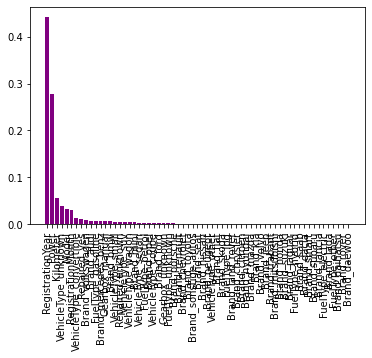

In [39]:
df = pd.DataFrame(data={"Features": features.columns,"Importance": model.feature_importances_}).sort_values(by="Importance",ascending=False)
plt.bar(x=df["Features"],height=df["Importance"],color="purple")
plt.xticks(rotation="vertical")
plt.show()

models_result["1st Importance"]["DecisionTreeRegressor_friedman_mse"] = df["Features"][0]
models_result["2nd Importance"]["DecisionTreeRegressor_friedman_mse"] = df["Features"][1]
models_result["3rd Importance"]["DecisionTreeRegressor_friedman_mse"] = df["Features"][2]

**DecisionTreeRegressor_poisson**

In [40]:
%%time
start_time = time()

model = DecisionTreeRegressor(criterion="poisson",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_valid)
prediction_time = time()

models_result["RMSE"]["DecisionTreeRegressor_poisson"] = score_print(predicted,target_valid)
models_result["TrainTime"]["DecisionTreeRegressor_poisson"] = round(train_time - start_time,2)
models_result["PredictionTime"]["DecisionTreeRegressor_poisson"] = round(prediction_time - train_time,2)

RMSE: 2413.45
CPU times: user 9.41 s, sys: 79.9 ms, total: 9.49 s
Wall time: 9.5 s


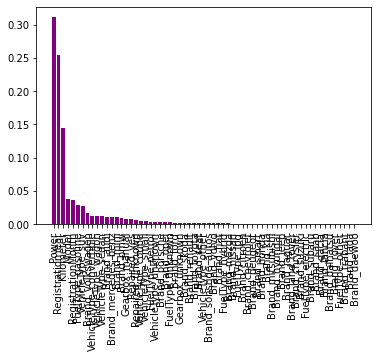

In [41]:
df = pd.DataFrame(data={"Features": features.columns,"Importance": model.feature_importances_}).sort_values(by="Importance",ascending=False)
plt.bar(x=df["Features"],height=df["Importance"],color="purple")
plt.xticks(rotation="vertical")
plt.show()

models_result["1st Importance"]["DecisionTreeRegressor_poisson"] = df["Features"][0]
models_result["2nd Importance"]["DecisionTreeRegressor_poisson"] = df["Features"][1]
models_result["3rd Importance"]["DecisionTreeRegressor_poisson"] = df["Features"][2]

### LightGBM

**LGBMRegressor_gbdt**

In [42]:
%%time
start_time = time()

model = LGBMRegressor(boosting_type="gbdt",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_valid)
prediction_time = time()

models_result["RMSE"]["LGBMRegressor_gbdt"] = score_print(predicted,target_valid)
models_result["TrainTime"]["LGBMRegressor_gbdt"] = round(train_time - start_time,2)
models_result["PredictionTime"]["LGBMRegressor_gbdt"] = round(prediction_time - train_time,2)

RMSE: 1762.1
CPU times: user 6.72 s, sys: 95.5 ms, total: 6.81 s
Wall time: 6.85 s


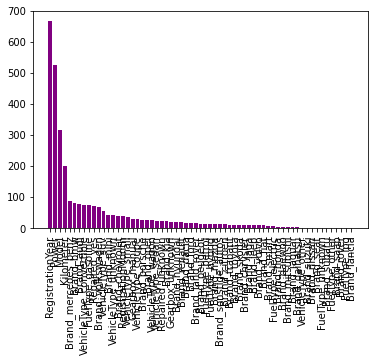

In [43]:
df = pd.DataFrame(data={"Features": features.columns,"Importance": model.feature_importances_}).sort_values(by="Importance",ascending=False)
plt.bar(x=df["Features"],height=df["Importance"],color="purple")
plt.xticks(rotation="vertical")
plt.show()

models_result["1st Importance"]["LGBMRegressor_gbdt"] = df["Features"][0]
models_result["2nd Importance"]["LGBMRegressor_gbdt"] = df["Features"][1]
models_result["3rd Importance"]["LGBMRegressor_gbdt"] = df["Features"][2]

**LGBMRegressor_dart**

In [44]:
%%time
start_time = time()

model = LGBMRegressor(boosting_type="dart",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_valid)
prediction_time = time()

models_result["RMSE"]["LGBMRegressor_dart"] = score_print(predicted,target_valid)
models_result["TrainTime"]["LGBMRegressor_dart"] = round(train_time - start_time,2)
models_result["PredictionTime"]["LGBMRegressor_dart"] = round(prediction_time - train_time,2)

RMSE: 1972.13
CPU times: user 18.6 s, sys: 153 ms, total: 18.8 s
Wall time: 18.9 s


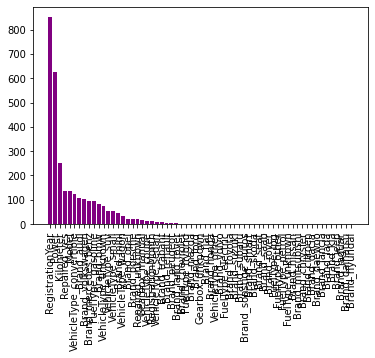

In [45]:
df = pd.DataFrame(data={"Features": features.columns,"Importance": model.feature_importances_}).sort_values(by="Importance",ascending=False)
plt.bar(x=df["Features"],height=df["Importance"],color="purple")
plt.xticks(rotation="vertical")
plt.show()

models_result["1st Importance"]["LGBMRegressor_dart"] = df["Features"][0]
models_result["2nd Importance"]["LGBMRegressor_dart"] = df["Features"][1]
models_result["3rd Importance"]["LGBMRegressor_dart"] = df["Features"][2]

### CatBoost

**CatBoostRegressor_SymmetricTree**

In [46]:
%%time
start_time = time()

model = CatBoostRegressor(logging_level="Silent",grow_policy="SymmetricTree",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_valid)
prediction_time = time()

models_result["RMSE"]["CatBoostRegressor_SymmetricTree"] = score_print(predicted,target_valid)
models_result["TrainTime"]["CatBoostRegressor_SymmetricTree"] = round(train_time - start_time,2)
models_result["PredictionTime"]["CatBoostRegressor_SymmetricTree"] = round(prediction_time - train_time,2)

RMSE: 1668.47
CPU times: user 33 s, sys: 333 ms, total: 33.4 s
Wall time: 34.8 s


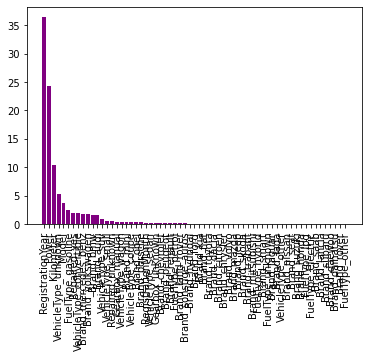

In [47]:
df = pd.DataFrame(data={"Features": features.columns,"Importance": model.feature_importances_}).sort_values(by="Importance",ascending=False)
plt.bar(x=df["Features"],height=df["Importance"],color="purple")
plt.xticks(rotation="vertical")
plt.show()

models_result["1st Importance"]["CatBoostRegressor_SymmetricTree"] = df["Features"][0]
models_result["2nd Importance"]["CatBoostRegressor_SymmetricTree"] = df["Features"][1]
models_result["3rd Importance"]["CatBoostRegressor_SymmetricTree"] = df["Features"][2]

**CatBoostRegressor_Depthwise**

In [48]:
%%time
start_time = time()

model = CatBoostRegressor(logging_level="Silent",grow_policy="Depthwise",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_valid)
prediction_time = time()

models_result["RMSE"]["CatBoostRegressor_Depthwise"] = score_print(predicted,target_valid)
models_result["TrainTime"]["CatBoostRegressor_Depthwise"] = round(train_time - start_time,2)
models_result["PredictionTime"]["CatBoostRegressor_Depthwise"] = round(prediction_time - train_time,2)

RMSE: 1638.1
CPU times: user 1min 12s, sys: 505 ms, total: 1min 13s
Wall time: 1min 14s


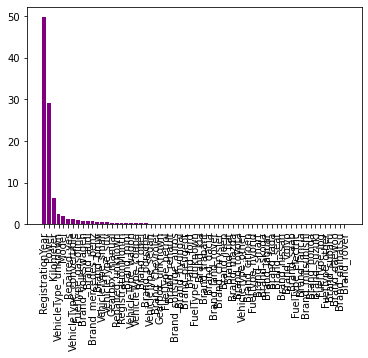

In [49]:
df = pd.DataFrame(data={"Features": features.columns,"Importance": model.feature_importances_}).sort_values(by="Importance",ascending=False)
plt.bar(x=df["Features"],height=df["Importance"],color="purple")
plt.xticks(rotation="vertical")
plt.show()

models_result["1st Importance"]["CatBoostRegressor_Depthwise"] = df["Features"][0]
models_result["2nd Importance"]["CatBoostRegressor_Depthwise"] = df["Features"][1]
models_result["3rd Importance"]["CatBoostRegressor_Depthwise"] = df["Features"][2]

**CatBoostRegressor_Lossguide**

In [50]:
%%time
start_time = time()

model = CatBoostRegressor(logging_level="Silent",grow_policy="Lossguide",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
train_time = time()
predicted = model.predict(features_valid)
prediction_time = time()

models_result["RMSE"]["CatBoostRegressor_Lossguide"] = score_print(predicted,target_valid)
models_result["TrainTime"]["CatBoostRegressor_Lossguide"] = round(train_time - start_time,2)
models_result["PredictionTime"]["CatBoostRegressor_Lossguide"] = round(prediction_time - train_time,2)

RMSE: 1643.56
CPU times: user 1min 26s, sys: 621 ms, total: 1min 27s
Wall time: 1min 28s


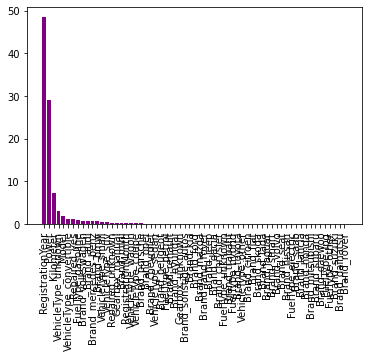

In [51]:
df = pd.DataFrame(data={"Features": features.columns,"Importance": model.feature_importances_}).sort_values(by="Importance",ascending=False)
plt.bar(x=df["Features"],height=df["Importance"],color="purple")
plt.xticks(rotation="vertical")
plt.show()

models_result["1st Importance"]["CatBoostRegressor_Lossguide"] = df["Features"][0]
models_result["2nd Importance"]["CatBoostRegressor_Lossguide"] = df["Features"][1]
models_result["3rd Importance"]["CatBoostRegressor_Lossguide"] = df["Features"][2]

#### Dummy model

**DummyRegressor**

In [56]:
%%time
start_time = time()

dummy_model = DummyRegressor()
dummy_model.fit(features_train,target_train)
train_time = time()
dummy_result = model.predict(features_valid)
prediction_time = time()

models_result["RMSE"]["DummyRegressor"] = score_print(dummy_result,target_valid)
models_result["TrainTime"]["DummyRegressor"] = round(train_time - start_time,2)
models_result["PredictionTime"]["DummyRegressor"] = round(prediction_time - train_time,2)

RMSE: 1668.47
CPU times: user 42.9 ms, sys: 32 µs, total: 43 ms
Wall time: 40.3 ms


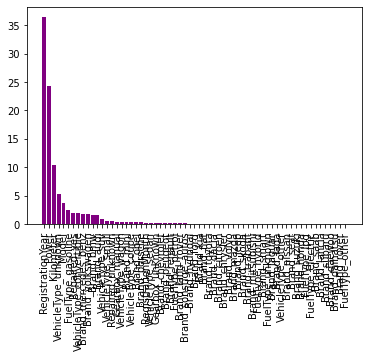

In [57]:
df = pd.DataFrame(data={"Features": features.columns,"Importance": model.feature_importances_}).sort_values(by="Importance",ascending=False)
plt.bar(x=df["Features"],height=df["Importance"],color="purple")
plt.xticks(rotation="vertical")
plt.show()

models_result["1st Importance"]["DummyRegressor"] = "-"
models_result["2nd Importance"]["DummyRegressor"] = "-"
models_result["3rd Importance"]["DummyRegressor"] = "-"

## Анализ Моделей

#### Общий анализ

In [58]:
display(models_result)

,RMSE,TrainTime,PredictionTime,1st Importance,2nd Importance,3rd Importance
LinearRegression_auto,2857.57,3.28,0.19,RegistrationYear,Power,Model
RandomForestRegressor_friedman_mse,1712.1,206.77,1.88,RegistrationYear,Power,Model
RandomForestRegressor_poisson,1974.31,601.29,2.55,RegistrationYear,Power,Model
DecisionTreeRegressor_friedman_mse,2219.73,3.28,0.03,RegistrationYear,Power,Model
DecisionTreeRegressor_poisson,2413.45,9.46,0.04,RegistrationYear,Power,Model
LGBMRegressor_gbdt,1762.1,6.45,0.39,RegistrationYear,Power,Model
LGBMRegressor_dart,1972.13,18.52,0.29,RegistrationYear,Power,Model
CatBoostRegressor_SymmetricTree,1668.47,34.72,0.04,RegistrationYear,Power,Model
CatBoostRegressor_Depthwise,1638.1,73.67,0.63,RegistrationYear,Power,Model
CatBoostRegressor_Lossguide,1643.56,87.85,0.56,RegistrationYear,Power,Model


**Вывод:**

- Самая быстрая модель по обучению - DecisionTreeRegressor_friedman_mse
- Самая быстрая модель по предсказанию - DecisionTreeRegressor_friedman_mse
- Самая быстрая модель с хорошим качеством (RMSE < 2000) - CatBoostRegressor_SymmetricTree
- Самая качественная модель - CatBoostRegressor_Depthwise
- Лучшая модель по время.качество - CatBoostRegressor_SymmetricTree
- Самая медленная модель по обучению - RandomForestRegressor_poisson
- Самая медленная модель по предсказанию - RandomForestRegressor_poisson
- Самая не качественная модель - LinearRegression_auto
- Все модели показали себя лучше, чем дефолтная модель
- Самым важным признаком является "RegistrationYear"

### Проверка на тестовой выборке

Проверим лучшую модель по время.качество на тестовой выборке:

In [59]:
start_time = time()

model = CatBoostRegressor(logging_level="Silent",grow_policy="SymmetricTree",random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predicted = model.predict(features_test)

print("Общее время:",round(time() - start_time,2))
print("RMSE:",round(rmse(predicted,target_test),2))

Общее время: 38.09
RMSE: 1646.09


**Вывод:**

Модель подтвердила свое качество и скорость работы на тестовой выборке. 

## Общий вывод

В ходе проекта были проанализированы данные и проведена их предобработка. Данные были подготовлены к обучению моделей и их проверки. По результатам моделирования, модель CatBoostRegressor_SymmetricTree показала себя лучше всего с хорошим соотношением качества и скорости работы. Показатель RMSE на тестовой выборке показал 1646, а скорость обучения и предсказания была равно 38 секунд.

В результате, данные и модель обученная на данных может быть использована для подсчета рыночной стоимости автомобиля для сервиса "Не бит, не крашен" 